<a href="https://colab.research.google.com/github/ianhstudent/ColabMLNotebook/blob/JPRSubmission/Bootstrap_LogisticRegression_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

In [ ]:
# Upload the data file with observations

from google.colab import files
fn = files.upload()


Saving Term&Preterm_AllSamples_20240404.csv to Term&Preterm_AllSamples_20240404.csv


In [ ]:
import io

# Adjust to read the uploaded file (name should already be provided after the upload)
data = pd.read_csv(io.BytesIO(fn['Term&Preterm_AllSamples_20240404.csv']))

print(data)

     Group       Thymine  4-Aminohippuric acid  5-Aminopentanamide  \
0        0  16148.476140           8415.820791         6905.938406   
1        0  24901.941100           8256.863739        14832.413540   
2        0   7641.399579           3974.474322         8179.276112   
3        0  14861.731150           3597.318170         7409.747105   
4        0  24297.212620           1230.643149          999.343056   
..     ...           ...                   ...                 ...   
145      1  12481.279420           6060.336998        11573.555520   
146      1  10958.468430           4564.755171         2608.258373   
147      1   9084.021333           1522.630155         1265.233521   
148      1  29612.010220           3227.926086         1788.734921   
149      1  12011.645970           1581.129616         1996.768786   

     5-Hydroxyoctanoylcarnitine (C10:0-OH)  Acetylcarnitine  Acetylcholine  \
0                             542037.60150     18407.927030    66215.74512   
1  

In [ ]:
# Check the number of features in the data file

n_features = data.shape[1]
print(n_features)

182


In [ ]:
X = data.drop(columns=['Group'])  # All columns except 'Group'
y = data['Group']  # Replace with your target column

print(X)

          Thymine  4-Aminohippuric acid  5-Aminopentanamide  \
0    16148.476140           8415.820791         6905.938406   
1    24901.941100           8256.863739        14832.413540   
2     7641.399579           3974.474322         8179.276112   
3    14861.731150           3597.318170         7409.747105   
4    24297.212620           1230.643149          999.343056   
..            ...                   ...                 ...   
145  12481.279420           6060.336998        11573.555520   
146  10958.468430           4564.755171         2608.258373   
147   9084.021333           1522.630155         1265.233521   
148  29612.010220           3227.926086         1788.734921   
149  12011.645970           1581.129616         1996.768786   

     5-Hydroxyoctanoylcarnitine (C10:0-OH)  Acetylcarnitine  Acetylcholine  \
0                             542037.60150     18407.927030    66215.74512   
1                             705404.28280     27834.145230    58401.76965   
2        

In [ ]:
# Exclude features with over 50% missing values
missing_threshold = 0.5  # 50% threshold
X = X.loc[:, data.isna().mean() <= missing_threshold]

n_features = X.shape[1]
print(n_features)

175


In [ ]:
# Handle missing values in the remaining features using KNN imputation

imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors as needed
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)


In [ ]:
# Perform z-score normalization via a stand scaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

print(X_scaled)

[[ 0.28301548 -0.25640328 -0.25227175 ...  0.09403202  0.20351549
  -0.90407469]
 [ 1.6269845  -0.27395635  1.40909904 ... -0.09750252  1.31165686
  -0.54872333]
 [-1.02312414 -0.74684555  0.01461688 ... -0.8844403  -0.14631883
  -1.15568279]
 ...
 [-0.80163026 -1.01759407 -1.4345504  ... -1.02065451 -0.77471925
  -1.3305173 ]
 [ 2.35014808 -0.82928424 -1.32482572 ... -0.90865676 -0.57308639
  -1.04672183]
 [-0.35213547 -1.01113418 -1.28122231 ... -0.91131114 -0.80402271
  -0.98240467]]


Here we are done with chekcking data for missing values and remove the ones with too many missing values. We also performed log transformation of the data. Next we check on the target file to decide the approach to analyze each target variable.

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Set the number of bootstrap samples
n_iterations = 100

# Initialize lists to store sample fpr, tpr, and auc
sample_fpr = []
sample_tpr = []
sample_auc = []
mean_fpr = np.linspace(0, 1, 100)
tprs = []

# Initialize lists to store accuracy
sample_accuracy = []

# Convert 0 to False and 1 to True
y_train_bool = np.array(y_train, dtype=bool)

# Initialize arrays to store predicted probabilities
train_probas = np.zeros((n_iterations, X_train.shape[0]))
test_probas = np.zeros((n_iterations, X_test.shape[0]))

# Initialize lists to store the confusion matrices
confusion_matrices = []

In [ ]:
# Interpolate the mean FPR
from scipy.interpolate import interp1d

# Perform bootstrap iterations
for i in range(n_iterations):
    # Bootstrap sample
    indices = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=True)
    X_train_boot = X_train[indices]
    y_train_boot = y_train_bool[indices]

    # Train an XGBoost classifier on the bootstrap sample
    alpha = 1.0  # You can adjust the regularization strength (alpha)
    model = LogisticRegression(C=1/alpha, solver='liblinear', random_state=42)

    # Perform k-fold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train, test in cv.split(X_train_boot, y_train_boot):
        X_train_fold, X_test_fold, y_train_fold, y_test_fold = X_train_boot[train], X_train_boot[test], y_train_boot[train], y_train_boot[test]

        # Fit the model
        model.fit(X_train_fold, y_train_fold)

        # Make predictions
        y_scores = model.predict_proba(X_test_fold)[:, 1]

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test_fold, y_scores)
        mean_tpr = np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        tprs.append(mean_tpr)

        # Calculate AUC
        roc_auc = auc(mean_fpr, mean_tpr)
        sample_auc.append(roc_auc)

        # Calculate Accuracy
        y_pred = np.round(y_scores).astype(int)
        acc = accuracy_score(y_test_fold, y_pred)
        sample_accuracy.append(acc)

        # Calculate the confusion matrix for this iteration
        cm = confusion_matrix(y_test_fold, y_pred, labels=[0, 1])
        confusion_matrices.append(cm)

    # Predict probabilities for the entire training and testing datasets
    if i == 0:  # Initialize arrays on first iteration
        train_probas = np.zeros((n_iterations, X_train.shape[0]))
        test_probas = np.zeros((n_iterations, X_test.shape[0]))

    train_probas[i] = model.predict_proba(X_train)[:, 1]
    test_probas[i] = model.predict_proba(X_test)[:, 1]


In [ ]:
# Compute mean and standard deviation of the ROC
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)



# Calculate the mean and standard deviation of the auc and accuracy
mean_auc = np.mean(sample_auc)
std_auc = np.std(sample_auc)
mean_accuracy = np.mean(sample_accuracy)
std_accuracy = np.std(sample_accuracy)

# Calculate the confidence interval for AUC
alpha = 0.95
lower_auc = np.percentile(sample_auc, (1 - alpha) / 2 * 100)
upper_auc = np.percentile(sample_auc, (alpha + (1 - alpha) / 2) * 100)

lower_accuracy = np.percentile(sample_accuracy, (1 - alpha) / 2 * 100)
upper_accuracy = np.percentile(sample_accuracy, (alpha + (1 - alpha) / 2) * 100)



# Display the confidence interval for AUC and accuracy
print(f"Bootstrap Confidence Interval for AUC: {alpha*100}%")
print(f"Lower bound AUC: {lower_auc:.3f}")
print(f"Upper bound AUC: {upper_auc:.3f}")
print(f"Bootstrap Confidence Interval for Accuracy: {alpha*100}%")
print(f"Lower bound Accuracy: {lower_accuracy:.3f}")
print(f"Upper bound Accuracy: {upper_accuracy:.3f}")
print(f"Mean auc: {mean_auc:.3f}")
print(f"Mean Accuracy: {mean_accuracy:.3f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.3f}")

Bootstrap Confidence Interval for AUC: 95.0%
Lower bound AUC: 0.590
Upper bound AUC: 0.980
Bootstrap Confidence Interval for Accuracy: 95.0%
Lower bound Accuracy: 0.603
Upper bound Accuracy: 0.958
Mean auc: 0.808
Mean Accuracy: 0.791
Standard Deviation of Accuracy: 0.088


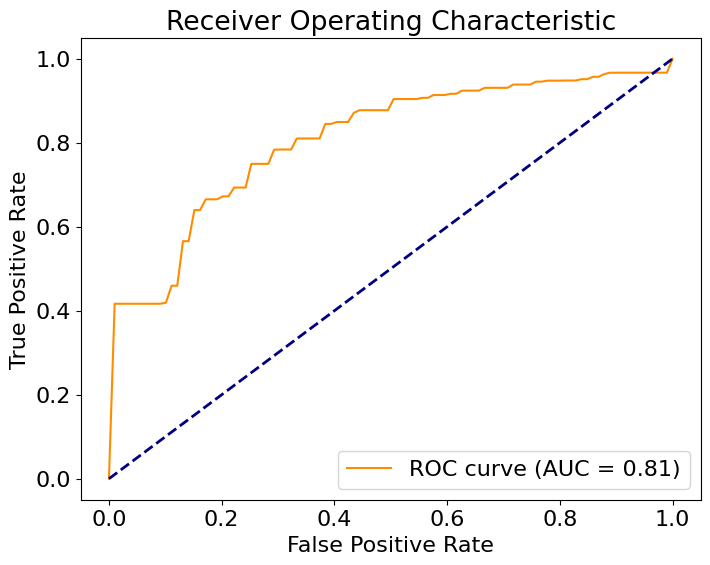

In [ ]:
import matplotlib.pyplot as plt

# Plot the mean ROC curve
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

plt.plot(mean_fpr, mean_tpr, color='darkorange', label=f'ROC curve (AUC = {mean_auc:.2f})')

# Plot the confidence interval for the ROC curve using bootstrapped percentiles
percentiles = np.percentile(tprs, [(1 - alpha) / 2 * 100, (alpha + (1 - alpha) / 2) * 100], axis=0)
lower_tpr_percentile, upper_tpr_percentile = percentiles


plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Show the plot
plt.show()

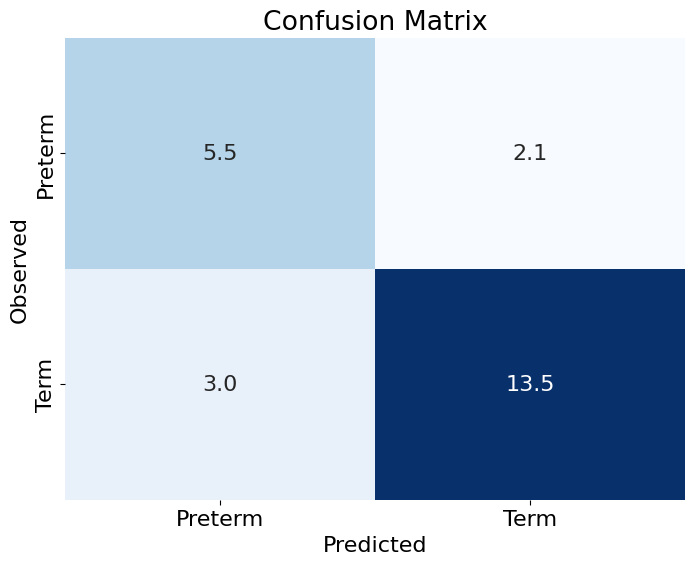

In [ ]:
import seaborn as sns

# Ensure all confusion matrices are 2x2 and pad if necessary
def pad_confusion_matrix(cm, shape=(2, 2)):
    padded_cm = np.zeros(shape, dtype=int)
    for i in range(min(shape[0], cm.shape[0])):
        for j in range(min(shape[1], cm.shape[1])):
            padded_cm[i, j] = cm[i, j]
    return padded_cm

padded_confusion_matrices = [pad_confusion_matrix(cm) for cm in confusion_matrices]

# Stack padded confusion matrices and calculate mean
padded_confusion_matrices = np.stack(padded_confusion_matrices)
average_cm = np.mean(padded_confusion_matrices, axis=0)


plt.figure(figsize=(8, 6))

plt.rcParams.update({'font.size': 16})  # Adjust font size as needed

sns.heatmap(average_cm, annot=True, fmt='.1f', cmap='Blues', cbar=False,
            xticklabels=["Preterm", "Term"], yticklabels=["Preterm", "Term"])
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.title('Confusion Matrix')
plt.savefig('ConfusionMatrix.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()

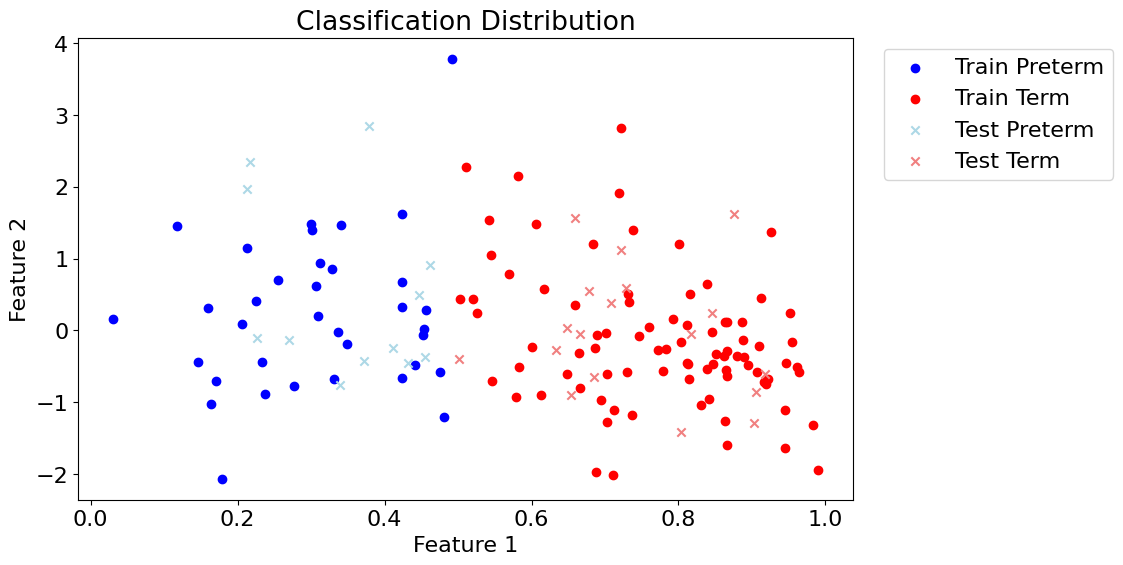

In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns

# Calculate average probabilities
avg_train_proba = np.mean(train_probas, axis=0)
avg_test_proba = np.mean(test_probas, axis=0)

# Predict classes using the average probabilities
y_train_pred_avg = np.round(avg_train_proba).astype(int)
y_test_pred_avg = np.round(avg_test_proba).astype(int)

# Create feature matrices including average predicted probabilities
X_train_cluster_avg = np.column_stack((avg_train_proba, X_train))  # Add average predicted probabilities as the first feature
X_test_cluster_avg = np.column_stack((avg_test_proba, X_test))

# Extract coordinates of data points for each class
train_class_0_points_avg = X_train_cluster_avg[y_train_pred_avg == 0]
train_class_1_points_avg = X_train_cluster_avg[y_train_pred_avg == 1]
test_class_0_points_avg = X_test_cluster_avg[y_test_pred_avg == 0]
test_class_1_points_avg = X_test_cluster_avg[y_test_pred_avg == 1]

# Plot data points

plt.figure(figsize=(10, 6))

plt.rcParams.update({'font.size': 16})  # Adjust font size as needed for all figures

plt.scatter(train_class_0_points_avg[:, 0], train_class_0_points_avg[:, 1], color='blue', label='Train Preterm')
plt.scatter(train_class_1_points_avg[:, 0], train_class_1_points_avg[:, 1], color='red', label='Train Term')
plt.scatter(test_class_0_points_avg[:, 0], test_class_0_points_avg[:, 1], color='lightblue', marker='x', label='Test Preterm')
plt.scatter(test_class_1_points_avg[:, 0], test_class_1_points_avg[:, 1], color='lightcoral', marker='x', label='Test Term')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Classification Distribution')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
plt.show()

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 8.6 MB/s eta 0:00:00


In [ ]:
#Shap evlauation of feature improtance
import shap

# Use SHAP to explain feature importances
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summarize the feature importance values
shap.summary_plot(shap_values, X_test, feature_names=X.columns)
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")